In [1]:
from scipy.stats import chi2, norm
from scipy.special import logsumexp
from matplotlib.pyplot import *
import numpy as np
import emcee, corner
import globalDetFunctions as gd
import LightkurveCacheAccess as lkAcc
import pandas as pd
import lightkurve as lk
import astropy.convolution as conv


In [27]:
download_dir = '/home/nielsemb/.lightkurve-cache'

ID = 'KIC8006161'
mission = 'Kepler'
cadence = 'short'
Teff = 5350
numaxGuess = 3500

#x, y, y_err = np.genfromtxt('/home/nielsemb/Downloads/HD79620_eleanor.csv', delimiter = ',').T
#lc = lk.LightCurve(time=x, flux=y, targetid=ID).remove_nans()

f, p, b = gd.tsToPsd(ID, download_dir, mission=mission, cadence=cadence)

--formatting name
--setting mission
--getting mast identifier
--performing search
--checking cache
--loading fits
---Loading files
---No of files 39
['/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2009231120729_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010111051353_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010140023957_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010174090439_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010203174610_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010234115140_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc

In [28]:
fb, pb, bb, dfb, Nbin = gd.binTheSpectrum(f, p, b, freqBinSize = 10)

In [29]:
#N, C = getSummedAcfMuCov(acf, 10, sparse = False)
lags, acf = gd.getTrimmedACF(f, p, b, freqBinSize = 0.01)
acfCov = np.std(acf[-5:])

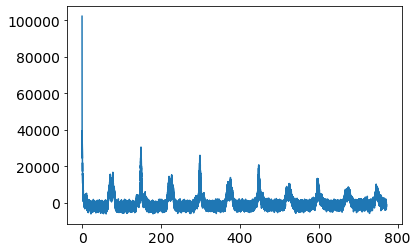

In [34]:
plot(lags, acf)
#xlim(0,200)

In [31]:
def smoothing(f, s, size = 0.1):
    fac = max([1, size / (f[1] - f[0])])
    kernel = conv.Gaussian1DKernel(stddev=fac)
    return conv.convolve(s, kernel)
    

In [32]:
smoo = smoothing(f, p)

(150.0, 285.0)

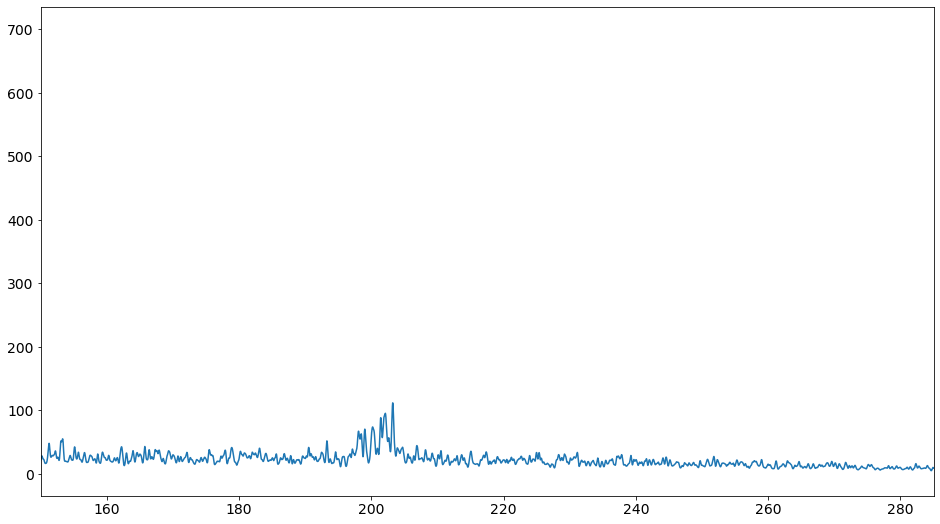

In [33]:
rcParams['font.size']=14
fig,ax =subplots(figsize = (16,9))
#ax.plot(f,p)
ax.plot(f, smoo, label = 'Smoothed spectrum')
ax.set_xlim(150,285)

In [ ]:
rcParams['font.size']=14
fig,ax =subplots(figsize = (16,9))
#ax.plot(f,p)
ax.plot(f, smoo, label = 'Smoothed spectrum')
ax.plot(f,b, label = 'Background estimate')
ax.set_xlabel('Frequency [$\mu$Hz]')
ax.set_ylabel('PSD [ppm$^2$/$\mu$Hz]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(2800, 5, 'p mode envelope')
ax.text(800, 2, 'Granulation background')
ax.text(250, 40, 'Uncorrected instrumental effect?')
legend()
ax.set_xlim(1e2,f[-1])
ax.set_ylim(2e-1, 1e2)
fig.savefig('envelope_background_charlie.png')

In [ ]:
rcParams['font.size']=14



for i,nu in enumerate([2500, 3500, 4500]):
    
    height = gd.envHeight(nu, Teff)*30
    width = gd.envWidth(nu, Teff) * np.sqrt(2.*np.log(2.))#/ 2
    env = gd.pmodeEnv(f, nu, height, width)#*np.sinc(0.5*f/f[-1])**2
    
    env_range = abs(f-nu) < width
    snr = smoo/b
    
    fig,ax =subplots(figsize = (11,6))
    ax.plot(f, smoo/b, label = 'Smoothed SNR', alpha = 0.5)
    ax.plot(f, env+1, label = 'Predicted envelope', color ='C3')

    ax.plot(f[env_range], snr[env_range], alpha = 0.75, label = 'Predicted FWHM')
    #ax.plot([nu, nu], [0, 2], lw = 5, color = 'k')

    ax.set_xlim(500,6500)
    ax.set_ylim(2e-1, 10)
    ax.set_xlabel('Frequency [$\mu$Hz]')
    ax.set_ylabel('PSD [ppm$^2$/$\mu$Hz]')
    ax.legend()
    fig.tight_layout()
    fig.savefig(f'snr_calculation_{i}.png')






# ax.set_xlabel('Frequency [$\mu$Hz]')
# ax.set_ylabel('PSD [ppm$^2$/$\mu$Hz]')
# #ax.set_xscale('log')
# #ax.set_yscale('log')
# legend()

# 
# fig.savefig('snr_calculation.png')

In [ ]:
SNR, SNR_pred, dof = np.array([gd.getSNR(nu, fb, pb, bb, Teff, f[-1], Nbin) for nu in fb]).T

lnpn = np.array([gd.numaxLogProbability(nu, fb, pb, bb, Teff, Nbin, fb[-1], numaxGuess) for nu in fb])

In [ ]:
fig, ax = subplots(figsize = (11,6))
ax.plot(fb, np.sum(lnpn[:,1:], axis = 1))
#ax.plot(fb, lnpn[:,-2])
#ax.plot(fb, lnpn[:,-3])
ax.set_ylim(-10,10)


In [ ]:
fig, ax = subplots(figsize = (11,6))
ax.plot(f, smoo/b/20+19/20, label = 'Smoothed spectrum', alpha = 0.25)

plot(fb, 1+SNR, lw = 3, label = 'SNR', color = 'C1')
plot(fb, 1+SNR_pred, lw = 3, label = 'Predicted SNR', color = 'C3')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend()
ax.set_xlim(2000, 5000)
ax.set_ylim(0.95, 1.4)
ax.set_xlabel('Frequency [$\mu$Hz]')
ax.set_ylabel('SNR')
fig.tight_layout()
fig.savefig('SNR_doris.png')

In [ ]:
import cpnest.model
import os

class nested(cpnest.model.Model):
    """
    Runs CPnest to performed nested sampling from

    log P(theta | D) ~ likelihood + prior

    Note both likelihood and prior are in natural log.

    Attributes
    ----------

    names: list, strings
        A list of names of the model parameters

    bounds: list of tuples
        The bounds of the model parameters as [(0, 10), (-1, 1), ...]

    likelihood: func
        Function that will return the log likelihood when called as 
        likelihood(params)

    prior: func
        Function that will return the log prior when called as prior(params)

    """
    
    def __init__(self, args, path):
        
        
        self.fb = args['fb']
        self.pb = args['pb']
        self.bb = args['bb']
        self.lags = args['lags']
        self.acf = args['acf']
        self.acfCov = args['acfCov']
        self.Nbin = args['Nbin']
        self.Nyquist = args['Nyquist']
        self.Teff = args['Teff']
        self.numaxGuess = args['numaxGuess']
        self.C = {'TeffRed0' : 9200,
                  'Teff0': 5777,
                  'numax0': 3050} # This should be 8907, but I seems to cut off some red-clump targets otherwise
        
        
        self.names=['numax', 'dnu', 'H', 'w', 'B']
        
        numaxTeffLim = self.C['numax0'] * ((self.Teff/self.C['TeffRed0']) * (args['Teff']/self.C['Teff0'])**0.47)**(1/0.11)
        self.bounds=[(max(0,fb[2],numaxTeffLim), self.fb[-1]),  # numax
                     (self.fb[1]-self.fb[0], max(self.lags)),  # dnu
                     (0, max(self.acf)), # H
                     (-3, 2), # width
                     (np.mean(acf[-5:])-3*np.std(acf[-5:]),np.mean(acf[-5:])+3*np.std(acf[-5:]))] # background
        
        print(self.bounds)
        
        
        self.path = os.path.join(*[path, 'cpnest'])
        if not os.path.isdir(self.path):
            os.mkdir(self.path)
        

    def log_likelihood(self, theta):
        """ Wrapper for log likelihood """
                  
        logp_dnu = gd.dnuLogProbability(theta.values[1:], self.lags, self.acf, self.acfCov)          
        
        logp_numax = gd.numaxLogProbability(theta.values[0], self.fb, self.pb, self.bb, 
                                        self.Teff, self.Nbin, self.Nyquist, 
                                        self.numaxGuess)  
        
        logp_dnuNumaxPrior = gd.dnuNumaxPrior(theta.values[0], theta.values[1])
        
        return np.sum(logp_numax) + logp_dnuNumaxPrior + logp_dnu

    def log_prior(self, theta):
        """ Wrapper for log prior """
        if not self.in_bounds(theta): 
            return -np.inf
        else:  
            return 0

    def __call__(self, nlive=300, nthreads=1, maxmcmc=100, poolsize=100):
        """
        Runs the nested sampling

        Parameters
        ----------
        nlive : int
            Number of live points to be used for the sampling. This is similar 
            to walkers in emcee. Default is 100.
        nthreads : int
            Number of parallel threads to run. More than one is currently slower
            since the likelihood is fairly quick to evaluate. Default is 1. 
        maxmcmc : int
            Maximum number of mcmc steps taken by the sampler. Default is 100.
        poolsize : int
            Number of objects for the affine invariant sampling. Default is 100.

        Returns
        -------
        df: pandas DataFrame
            A dataframe of the samples produced with the nested sampling.
        """
        
        self.nest = cpnest.CPNest(self, verbose=0, seed=53, nthreads=nthreads, 
                                  nlive=nlive, maxmcmc=maxmcmc, poolsize=poolsize, 
                                  output=self.path)
        
        self.nest.run()
        
        self.samples = self.nest.get_posterior_samples()
        
        return self.samples

In [ ]:
args = {'fb': fb, 
        'pb': pb, 
        'bb': bb, 
        'Nbin': Nbin,
        'Nyquist': f[-1],
        'lags': lags,
        'acf': acf,
        'acfCov': acfCov,
        'Teff': Teff,
        'numaxGuess': numaxGuess}

nestmodel = nested(args, '/home/nielsemb/work/repos/PSM128/getGlobal/')


In [ ]:
a = nestmodel(nlive=100, nthreads=1, maxmcmc=100, poolsize=100)

In [ ]:
hist(a['numax'], bins = 30)

In [ ]:
for nu in fb:
    logp_numax = gd.numaxLogProbability(nu, fb, pb, bb, Teff, Nbin, f[-1], numaxGuess)
    plot(nu, np.sum(logp_numax),'k.')
ylim(np.sum(logp_numax),100)

In [ ]:
from tqdm import tqdm

L = np.zeros((len(fb), len(lags)))
for i, nu in tqdm(enumerate(fb)):
    for j, lag in enumerate(lags):
 
        theta = [nu, lag, max(acf[5:]), np.log10(0.2), np.mean(acf[-5:])]

        logp_dnu = gd.dnuLogProbability(theta[1:], lags, acf, acfCov)          
        
        logp_numax = gd.numaxLogProbability(theta[0], fb, pb, bb, Teff, Nbin, f[-1], numaxGuess)  
        
        #logp_dnuNumaxPrior = gd.dnuNumaxPrior(theta[0], theta[1])
        
        L[i, j] = np.sum(logp_numax) + logp_dnu #+ logp_dnuNumaxPrior

In [ ]:
import pandas as pd
df = pd.read_csv('/home/nielsemb/work/repos/PBjam/pbjam/data/prior_data.csv')

In [ ]:
rcParams['font.size'] = 14

fig, ax = subplots(figsize=(9,7))
ax.contourf(fb, lags, L.T)
ax.set_xlabel(r'$\nu_{max}$')
ax.set_ylabel(r'$\Delta\nu$')
ax.set_ylim(0,25)
ax.set_xlim(fb[0], fb[-1])

ax.scatter(10**df['numax'], 10**df['dnu'], c = 'k', s = 4)

ax.plot(fb, gd.dnuScale(fb), color = 'C3', lw = 3)
ax.plot(fb, gd.dnuScale(fb)*(1+0.21), color = 'C3', ls = 'dashed')
ax.plot(fb, gd.dnuScale(fb)*(1-0.21), color = 'C3', ls = 'dashed')
fig.tight_layout()
#fig.savefig('dnu_numax_loglikelihood_0_prior.png')
#fig.savefig('dnu_numax_loglikelihood_1_prior.png')
fig.savefig('dnu_numax_loglikelihood_2_prior.png')
#Dnu / dnuScale(numax)-1
#xlim(0,50)

In [ ]:
idx=np.isinf(L)
L[idx] = np.nan

In [ ]:
la = np.nansum(L, axis = 0)

In [ ]:
plot(lags, acf)
#ylim(-0.2e4, 0.2e4)